# Feature Engineering investigation

In [359]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

train_start = '2021-05-01 00:00:00'
train_end = '2021-07-15 23:00:00'
test_start = '2021-07-16 00:00:00'
test_end = '2021-07-29 23:00:00'
# get label
label = pd.read_pickle('label.pkl')
train_label = pd.Series(label.loc[train_start:train_end].value)
test_label = pd.Series(label.loc[test_start:test_end].value)
# get feature matrix
features = pd.read_pickle('2021_features.pkl')
train_features = features.loc[train_start:train_end]
test_features = features.loc[test_start:test_end]


In [360]:
print(f'Original feature size: {features.shape}')
print(f'Training feature size: {train_features.shape}')
print(f'Test feature size: {test_features.shape}')
print('------------------------------------------')
print(f'Original label size: {label.shape}')
print(f'Training label size: {train_label.shape}')
print(f'Test labl size: {test_label.shape}')

Original feature size: (5111, 786)
Training feature size: (1824, 786)
Test feature size: (336, 786)
------------------------------------------
Original label size: (92784, 1)
Training label size: (1824,)
Test labl size: (336,)


## First layer feature filtering

In [361]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(train_features);
features_filtered = select_features(train_features, train_label)
print(features_filtered.shape)

(1824, 315)


## Second layer feature selection using Lasso Regression

In [362]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
def FeatureSelection(features_filtered, label):
    model = linear_model.Lasso(alpha=2)
    # standardization
    X = StandardScaler().fit_transform(np.array(features_filtered))
    y = np.array(label)
    model.fit(X, y)
    feature_coeff = pd.Series(model.coef_, index=features_filtered.columns)
    feature_coeff = feature_coeff.sort_values(ascending=False)
    feature_names = feature_coeff[feature_coeff.abs()>0].index
    return feature_names

In [363]:
relevant_feature_names = FeatureSelection(features_filtered, train_label)
train_X = StandardScaler().fit_transform(np.array(train_features[relevant_feature_names]))
test_X = StandardScaler().fit_transform(np.array(test_features[relevant_feature_names]))
print(train_X.shape)
print(test_X.shape)

(1824, 26)
(336, 26)


## Training ARIMA model

In [364]:
from pmdarima import auto_arima
model = auto_arima(train_label, max_p=8, max_q=8, max_order=None, \
    seasonal=False, m=24, \
    exogenous=train_X, \
    trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=9.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20679.148, Time=2.72 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=6.86 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=7.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11352.337, Time=6.79 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11311.539, Time=7.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=6.77 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11360.827, Time=12.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11371.180, Time=11.73 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=11.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=11.77 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11276.083, Time=8.79 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=11277.529, Time=9.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11274.961, Time=8.39 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11277.534

In [365]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
preds = model.predict_in_sample(train_X)
print("Train RMSE: %.3f" % np.sqrt(mean_squared_error(train_label, preds)))
print(f"Train SMAPE: {round(100 - smape(train_label, preds), 1)}%")

Train RMSE: 5.230
Train SMAPE: 88.6%


Text(0, 0.5, 'Price (€)')

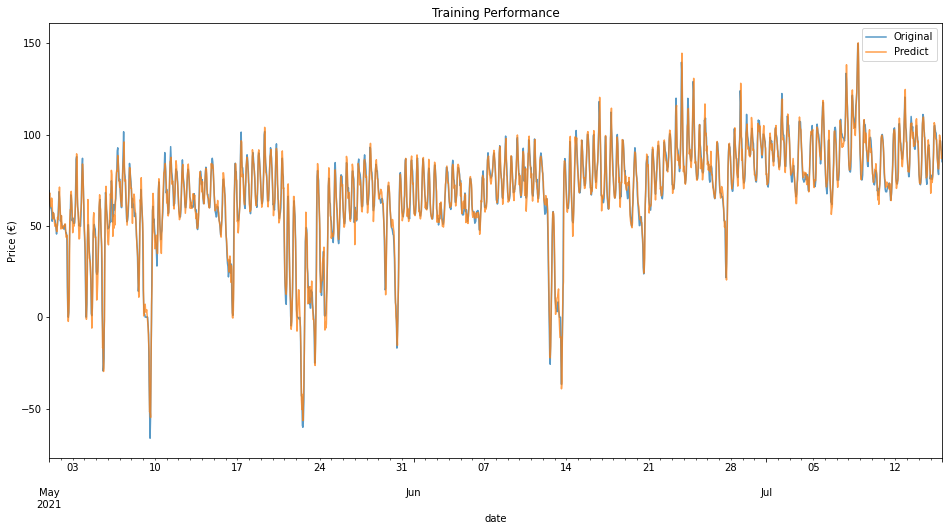

In [366]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(16,8))
train_label.plot(ax=ax, alpha=0.75)
forecast = pd.DataFrame({'date': train_label.index, 'value': preds}).set_index('date')
forecast.plot(ax=ax, alpha=0.75)  # Forecasts
# setting
ax.legend(['Original', 'Predict'])
plt.title("Training Performance")
plt.ylabel('Price (€)')

In [367]:
preds, conf_int = model.predict(n_periods=test_label.shape[0], X=test_X, return_conf_int=True)
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test_label, preds)))
print(f"Test SMAPE: {round(100 - smape(test_label, preds), 1)}%")

Test RMSE: 11.469
Test SMAPE: 79.9%


Text(0, 0.5, 'Price (€)')

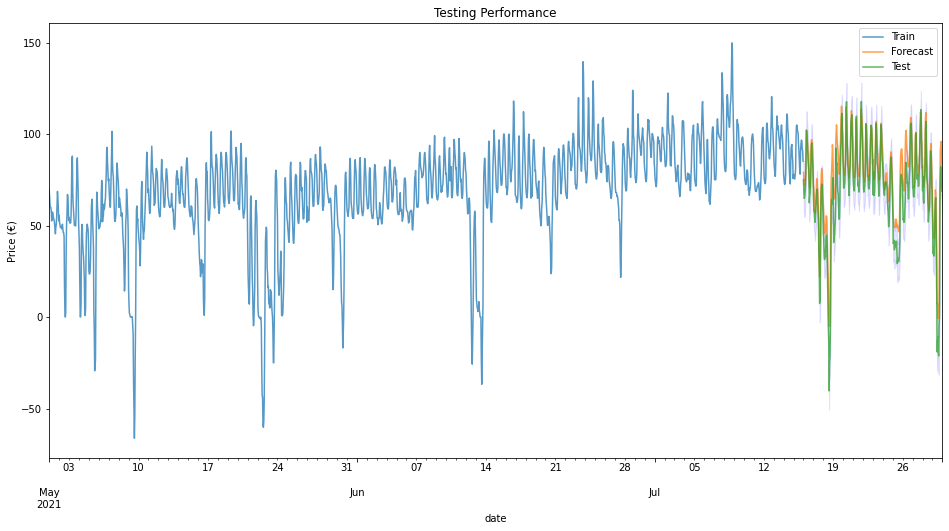

In [368]:
# visualization
fig, ax = plt.subplots(1,1,figsize=(16,8))
train_label.plot(ax=ax, alpha=0.75) # Training data
test_label.plot(ax=ax, alpha=0.75)  # Test data
forecast = pd.DataFrame({'date': test_label.index, 'value': preds}).set_index('date')
forecast.plot(ax=ax, alpha=0.75)  # Forecasts

# plot confidence interval
ax.fill_between(test_label.index, conf_int[:, 0], conf_int[:, 1], \
                  alpha=0.1, color='b')
plt.legend(['Train', 'Forecast', 'Test'])
plt.title("Testing Performance")
plt.ylabel('Price (€)')
# plt.xlim(['2011-03-01 23:00:00', '2011-04-02 23:00:00'])